<a href="https://colab.research.google.com/github/Abhishekjain113/Breast_cancer_dictation_CNN/blob/main/Breast_cancer_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

# importing google drive
from google.colab import drive
drive.mount('/content/drive')
     
  # This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

#required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL


Mounted at /content/drive


In [7]:

classes_types=['M', 'B','N']
data_dir = '//content/drive/MyDrive/Internship/Breast_Cancer_Dataset'
train_dir = os.path.join(data_dir)

     

In [8]:
train_data = []
for defects_id, sp in enumerate(classes_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Class ID','Class Type'])
train.head()


,File,Class ID,Class Type
0,M/mdb124.pgm,0,M
1,M/mdb117.pgm,0,M
2,M/mdb115.pgm,0,M
3,M/mdb058.pgm,0,M
4,M/mdb095.pgm,0,M


In [9]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()
     

,File,Class ID,Class Type
0,N/mdb108.pgm,2,N
1,N/mdb003.pgm,2,N
2,N/mdb122.pgm,2,N
3,M/mdb075.pgm,0,M
4,B/mdb165.pgm,1,B


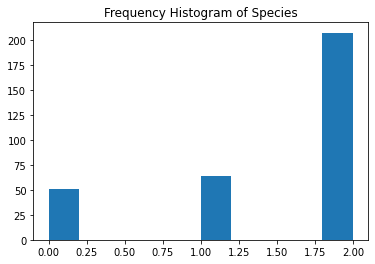

<Figure size 864x864 with 0 Axes>

In [10]:

plt.hist(train['Class ID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [11]:

IMAGE_SIZE = 224
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
    

In [12]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))
     

322it [01:27,  3.68it/s]


Train Shape: (322, 224, 224, 3)


In [13]:
Y_train = train['Class ID'].values
Y_train = to_categorical(Y_train, num_classes=3)

In [14]:

BATCH_SIZE = 64
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)
     

In [15]:

def create_AlexNet ():
    model = Sequential ()

    # First Convolutionary Layer
    
    #With 96 11x11 kernels, stride 4, enabling padding and with one input
    #de 224x224x3.
    model.add (Conv2D (filters = 96, input_shape = (224,224,3), kernel_size = (11,11), strides = (4,4), padding = 'valid'))
    model.add (Activation ('relu'))
    # Pooling layer, with a 2x2 kernel, 2 stride and padding enabled.
    model.add (MaxPooling2D (pool_size = (2,2), strides = (2,2), padding = 'valid'))
    # Batch Normalisation before moving on to the fifth layer.
    model.add (BatchNormalization ())

    # Second Convolutionary Layer
    
    #With 256 11x11 kernels, 4 stride, enabling padding.
    model.add (Conv2D (filters = 256, kernel_size = (11,11), strides = (1,1), padding = 'valid'))
    model.add (Activation ('relu'))
    # Pooling layer, with a 2x2 kernel, 2 stride and padding enabled.
    model.add (MaxPooling2D (pool_size = (2,2), strides = (2,2), padding = 'valid'))
    # Batch Normalisation before moving on to the fifth layer.
    model.add (BatchNormalization ())

    # Third Convolutionary Layer
    
    #With 384 3x3 kernels, stride of 1, enabling padding.
    model.add (Conv2D (filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
    model.add (Activation ('relu'))
    # Batch Standardization
    model.add (BatchNormalization ())

    # Fourth Convolutionary Layer
    
    #With 384 3x3 kernels, stride of 1, enabling padding.
    model.add (Conv2D (filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
    model.add (Activation ('relu'))
    # Batch Standardization
    model.add (BatchNormalization ())

    # Fifth Convolutionary Layer
    
    #With 256 3x3 kernels, stride of 1, enabling padding.
    model.add (Conv2D (filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid'))
    model.add (Activation ('relu'))
    # Pooling layer, with a 2x2 kernel, 2 stride and padding enabled.
    model.add (MaxPooling2D (pool_size = (2,2), strides = (2,2), padding = 'valid'))
    # Batch Standardization
    model.add (BatchNormalization ())

    # We go to the Fully Connected (FC) stage
    model.add (Flatten ())
    # First layer Dense
    model.add (Dense (4096))
    model.add (Activation ('relu'))
    # Dropout is introduced with probability equal to 0.4 to avoid overfitting.
    model.add (Dropout (0.4))
    # Batch Standardization
    model.add (BatchNormalization ())

    # Second layer Dense
    model.add (Dense (4096))
    model.add (Activation ('relu'))
    # # Dropout is introduced
    model.add (Dropout (0.4))
    # Batch Standardization
    model.add (BatchNormalization ())

    # Third layer Dense
    model.add (Dense (1000))
    model.add (Activation ('relu'))
    # Dropout is introduced
    model.add (Dropout (0.4))
    # Batch Standardization
    model.add (BatchNormalization ())

    # Output layer with 2 nodes, since the classification will be made between 2 categories
    model.add (Dense (17))
    model.add (Dense (3, activation = 'softmax'))
    
    return model

#AlexNet model is created as defined above
model = create_AlexNet ()
model.compile (loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

hist=model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)
     

Epoch 1/50
9/9 [==============================] - 57s 5s/step - loss: 3.4345 - accuracy: 0.3463 - val_loss: 19.0363 - val_accuracy: 0.7231
Epoch 2/50
9/9 [==============================] - 46s 5s/step - loss: 2.7331 - accuracy: 0.3696 - val_loss: 49.3976 - val_accuracy: 0.7231
Epoch 3/50
9/9 [==============================] - 50s 5s/step - loss: 2.1317 - accuracy: 0.3813 - val_loss: 28.5804 - val_accuracy: 0.7231
Epoch 4/50
9/9 [==============================] - 48s 5s/step - loss: 1.5550 - accuracy: 0.4163 - val_loss: 8.8148 - val_accuracy: 0.2769
Epoch 5/50
9/9 [==============================] - 46s 5s/step - loss: 1.2896 - accuracy: 0.4436 - val_loss: 36.3391 - val_accuracy: 0.1077
Epoch 6/50
9/9 [==============================] - 46s 5s/step - loss: 1.2987 - accuracy: 0.4514 - val_loss: 4.6553 - val_accuracy: 0.4308
Epoch 7/50
9/9 [==============================] - 47s 5s/step - loss: 1.1477 - accuracy: 0.4669 - val_loss: 9.6070 - val_accuracy: 0.1846
Epoch 8/50
9/9 [==============

3/3 [==============================] - 3s 648ms/step


Text(0.5, 145.31999999999996, 'Predicted')

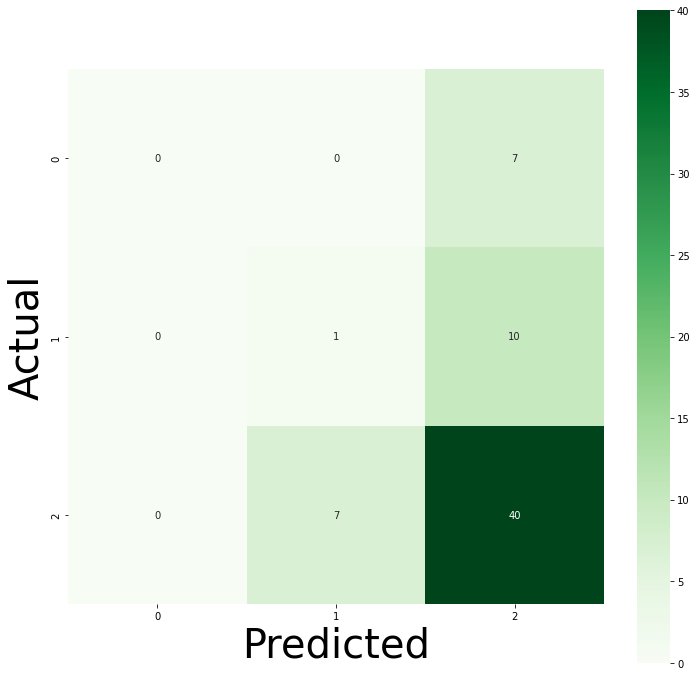

In [16]:

Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

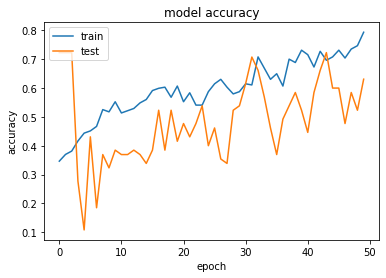

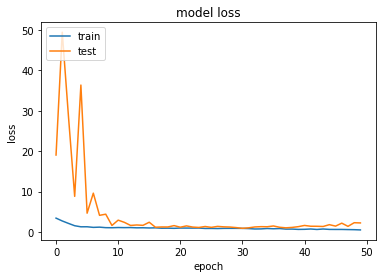

In [17]:

# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
     

1/1 [==============================] - 0s 116ms/step
[2.1829571e-04 2.1364561e-03 9.9764520e-01]


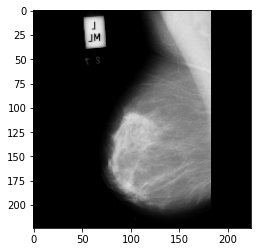

Prediction: N


In [18]:

from skimage import io
#path='imbalanced/Scratch/Scratch_400.jpg'
import keras.utils as image
img = image.load_img('/content/drive/MyDrive/Internship/Breast_Cancer_Dataset/M/mdb095.pgm', grayscale=False, target_size=(224, 224))
show_img=image.load_img('/content/drive/MyDrive/Internship/Breast_Cancer_Dataset/M/mdb095.pgm', grayscale=False, target_size=(224, 224))
disease_class=['M','B','N']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255
custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])